# Summarize the taxonomic composition of SRA RNA seq samples

This notebook summarizes the species-level breakdown of the RNA seq samples I have analyzed so far.
The species compositions were made using `sourmash gather`. `sourmash gather` compares one sequencing file (the query) against a database of genomes, and returns the minimum set of genomes that will cover (min set cov) all of the k-mers in the query file that are in the database.

By default, `sourmash gather` returns the following information:
+ `intersect_bp`: the estimated number of base pairs that overlapped between the query and the matched genome
+ `f_orig_query`: the fraction of the orginal query (RNA-seq sample) that matched against the genome
+ `f_match`: the fraction of the genome that matched against the original query (RNA-seq sample)
+ `f_unique_to_query`: the fraction of the matched genome that was unique to the query. Given that multiple matched genomes could cover the same portion of the query, this column reports the fraction of the query that was covered by the a matched genome, but doesn't allow multiple genomes to cover the same portion. As such, the genome that covers the most k-mers in an RNA-seq sample gets to "anchor" those k-mers, while other genomes that could cover those k-mers don't get any of them. This column removes the double counting problem that arises from having multiple genomes in a database that contain some of the same sequences.
+ `f_unique_weighted`: This column weights the f_unique_to_query by the abundance of those k-mers. This is important in the context of RNA-seq, as the abudnance reflects the expression of the sequence.

These numbers are all based on genome-level matches. This notebook first summarizes the results up to the species level using the GTDB taxonomy. 

The plots below are based on the `f_unique_to_query` and the `f_unique_weighted`.

In [1]:
setwd("..")

In [3]:
library(dplyr)
library(readr)
library(ggplot2)
library(ggthemes)
library(purrr)
library(tidyr)
source("scripts/utils.R")

## read in metadata and results

In [5]:
gtdb_lineages <- read_csv("inputs/gtdb-rs202.taxonomy.v2.csv", show_col_types = F)

In [6]:
# label by designated species
gather_to_ref_species <- Sys.glob("outputs/rnaseq_sourmash_gather_to_ref_species/*csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  select(query_name, ref_species = species)

In [7]:
gather <- Sys.glob("outputs/rnaseq_sourmash_gather/*csv") %>%
  map_dfr(read_gather) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  left_join(gtdb_lineages, by = c("accession" = "ident")) %>%
  mutate(species = ifelse(is.na(species) & accession == "GCF_000001405.39_GRCh38.p13_rna.fna.gz", "human", species)) %>%
  left_join(gather_to_ref_species, by = "query_name") %>%
  mutate(ref_species = ifelse(is.na(ref_species), "s__Pseudomonas aeruginosa", ref_species)) %>% # temporary line until i run this for Pa samples
  group_by(query_name) %>%
  mutate(total_f_unique_to_query = sum(f_unique_to_query),
         total_f_unique_weighted = sum(f_unique_weighted))

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”


## plot species-level summaries of RNA-seq taxonomic composition

This plot won't scale with many samples, but it's still fun to look at at this stage.

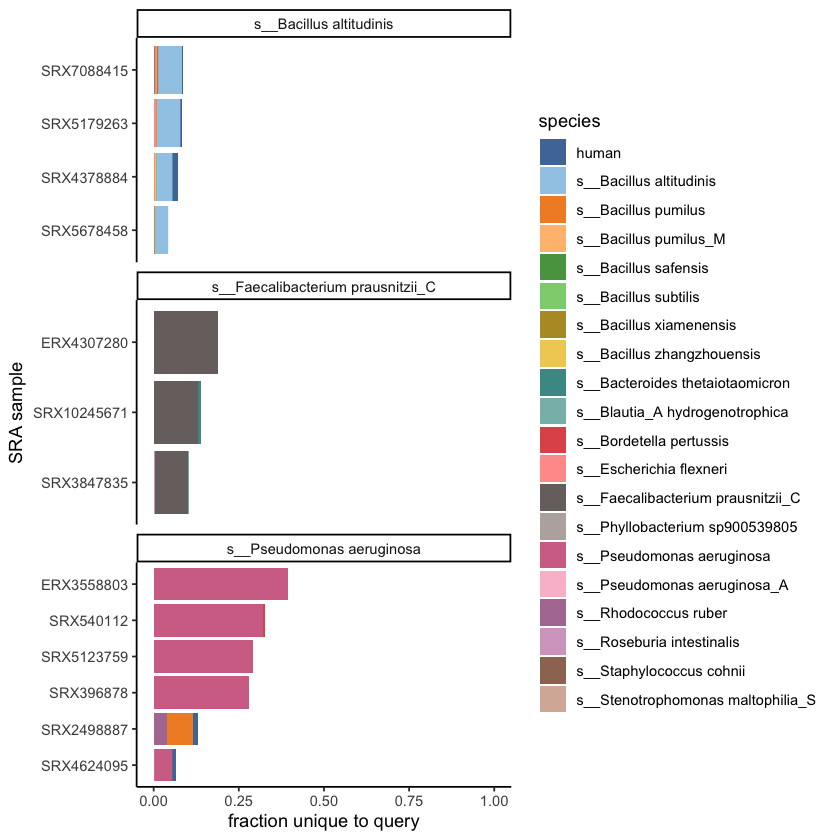

In [8]:
ggplot(gather, aes(x = reorder(query_name, total_f_unique_to_query), y = f_unique_to_query, fill = species)) +
  geom_col() +
  theme_classic() +
  ylim(0, 1) +
  coord_flip() +
  scale_fill_tableau(palette = "Tableau 20") +
  facet_wrap(~ref_species, scales = "free_y", nrow = 3) +
  labs(y = "fraction unique to query", x = "SRA sample")

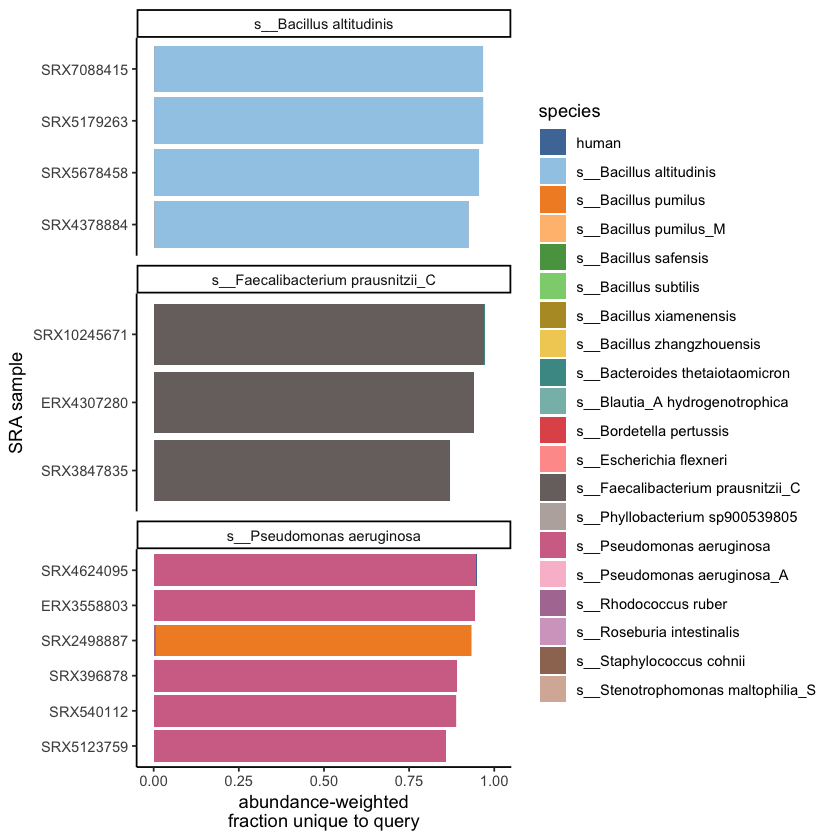

In [9]:
ggplot(gather, aes(x = reorder(query_name, total_f_unique_weighted), y = f_unique_weighted, fill = species)) +
  geom_col() +
  theme_classic() +
  ylim(0, 1) +
  coord_flip() +
  scale_fill_tableau(palette = "Tableau 20") +
  facet_wrap(~ref_species, scales = "free_y", nrow = 3)  +
  labs(y = "abundance-weighted\nfraction unique to query", x = "SRA sample")

## Calculate summary statistics

These plots should scale to many samples (e.g. when we eventually run this stuff on 60k transcriptomes)

In [10]:
gather_summary <- gather %>%
  select(query_name, ref_species) %>%
  distinct()

In [11]:
num_strains_of_same_species <- gather %>% 
  group_by(query_name, ref_species, species) %>%
  tally() %>%
  mutate(strains_of_same_species = ifelse(ref_species == species, n, 0)) %>%
  ungroup() %>%
  group_by(query_name) %>%
  summarize(num_strains_of_same_species = sum(strains_of_same_species))

In [12]:
num_contam_strains <- gather %>% 
  group_by(query_name, ref_species, species) %>%
  tally() %>%
  mutate(contam_strains = ifelse(ref_species == species, 0, n)) %>%
  ungroup() %>%
  group_by(query_name) %>%
  summarize(num_contam_strains = sum(contam_strains))

In [13]:
human_contam <- gather %>% 
  group_by(query_name, ref_species, species) %>%
  tally() %>%
  mutate(human_contam = ifelse(species == "human", 1, 0)) %>%
  ungroup() %>%
  select(query_name, human_contam) %>%
  filter(human_contam == 1)

In [14]:
gather_summary <- full_join(num_strains_of_same_species, num_contam_strains, by = "query_name") %>%
  full_join(human_contam, by = "query_name") %>%
  mutate(human_contam = ifelse(is.na(human_contam), 0, human_contam)) %>%
  left_join(gather_summary, by = "query_name")

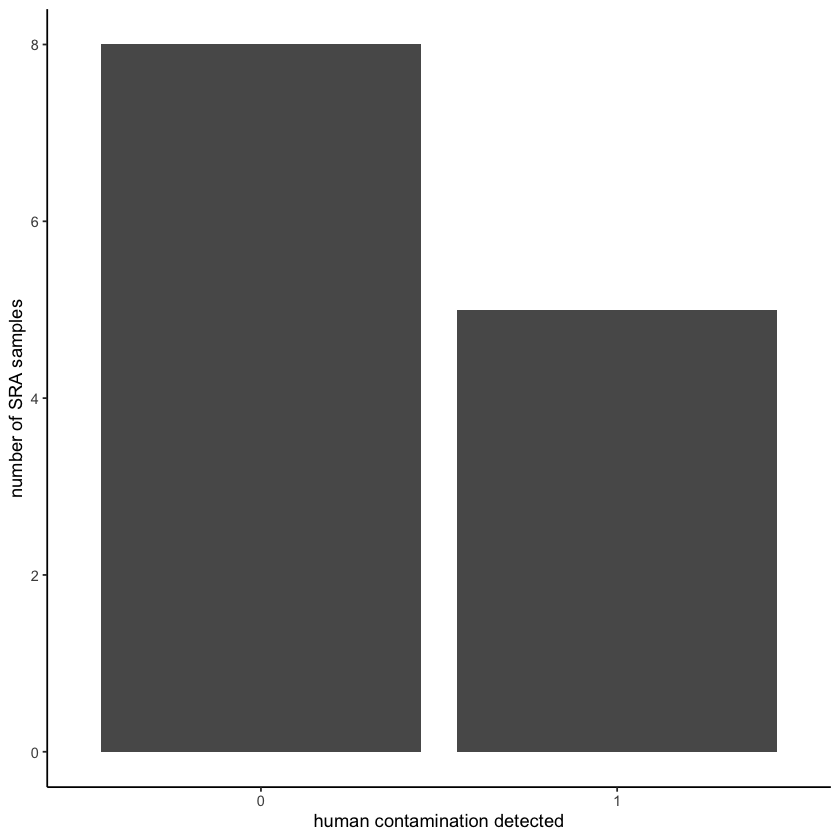

In [15]:
ggplot(gather_summary %>% group_by(human_contam) %>% tally(), 
       aes(x = as.factor(human_contam), y = n)) +
  geom_col() + 
  theme_classic() +
  labs(y = "number of SRA samples", x = "human contamination detected")

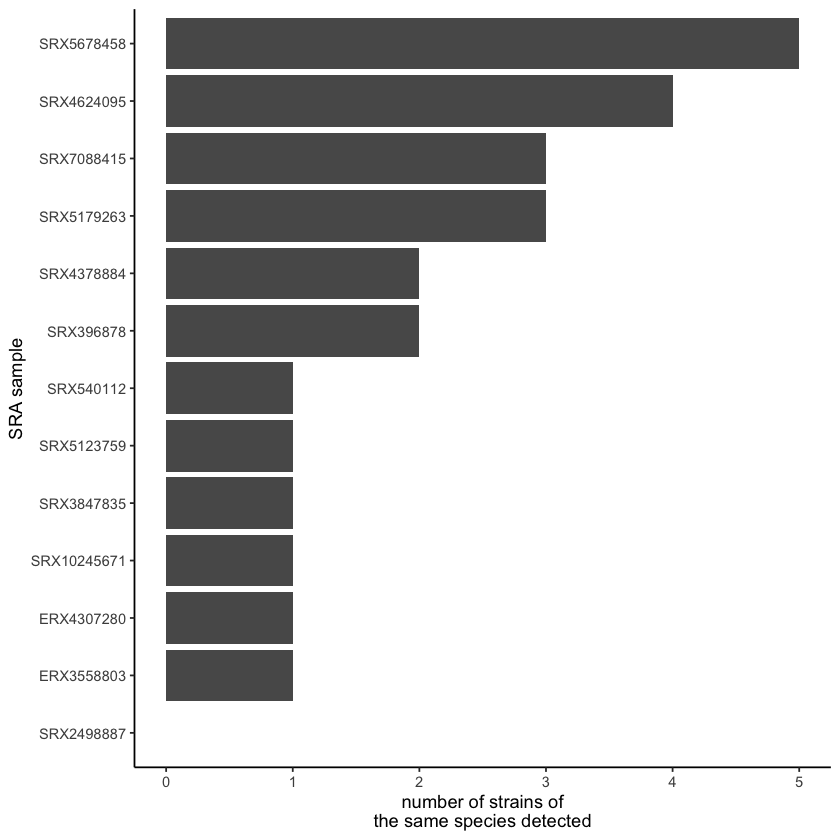

In [16]:
ggplot(gather_summary, aes(x = reorder(query_name, num_strains_of_same_species), y = num_strains_of_same_species)) +
  geom_col() +
  theme_classic() +
  labs(x = "SRA sample", y = "number of strains of\nthe same species detected") +
  coord_flip() 

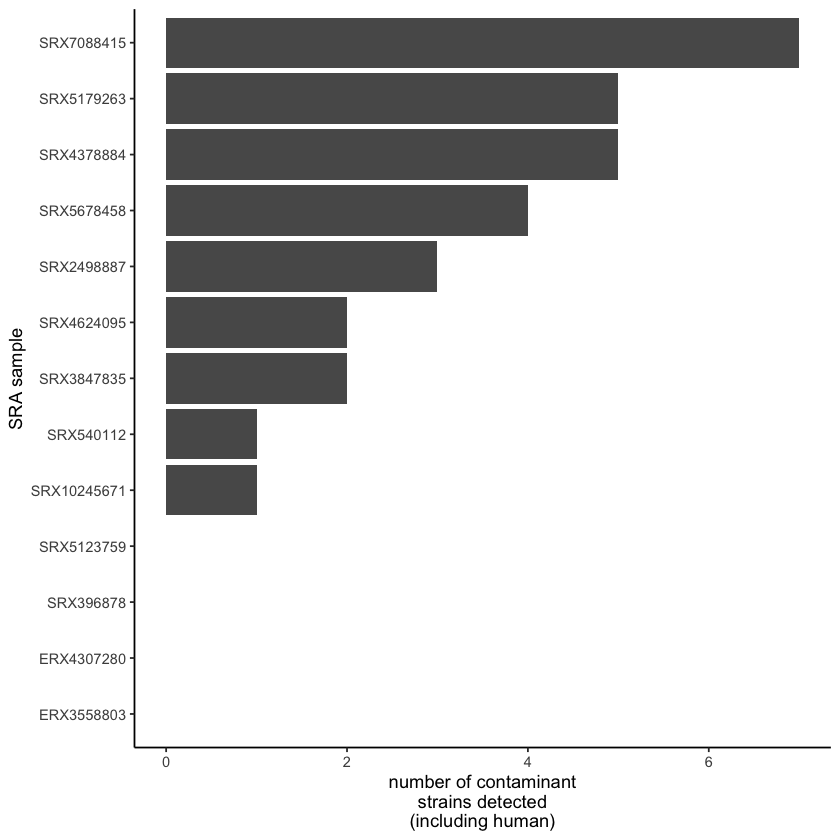

In [17]:
ggplot(gather_summary, aes(x = reorder(query_name, num_contam_strains), y = num_contam_strains)) +
  geom_col() +
  theme_classic() +
  labs(x = "SRA sample", y = "number of contaminant\nstrains detected\n(including human)") +
  coord_flip() 

## Conclusions

One thing this notebook makes clear is that it's important to look at the _abundance weighted_ fractions reported by `sourmash gather`. This is important because RNAseq data is highly duplicated given the high abundance of some expressed transripts in the original library.

## Still to do/next steps

+ write code to identify and visualize the number of times a strain was the reference strain within a species.
    + This plot will be more meaningful/rewarding when many RNA seq samples are analyzed instead of ~3 or 6 from a species
+ write code for summary statistics about the % of a sample identified, % unidentified, % contamination, etc.
+ write code to check if pairs of reference species and contaminants occur more frequently than would be expected by chance
    + wait until there are many more samples so this has a chance of making some sense